# 1D Gaussian DSM

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


# DSM Loss
**Notation**

- $x_0$: original data;
- $p_0(x_0)$: data distribution of original data;
- $x$: noisy data (by perturbing the original data);
- $p(x \mid x_0)$: conditional (noisy) data distribution;
- $p_\sigma(x)$: (noisy) data distribution.

We also note that  
$$
p_\sigma(x) = \int_{\mathbb{R}^d} p(x \mid x_0)\, p_0(x_0)\, dx_0.
$$

The goal of denoising score matching is to find the **noisy score function**  
$$
S_\sigma(x; \theta) = \nabla_x \log p_\sigma(x).
$$

The DSM objective can be written as  
$$
L_{\text{DSM}}(\theta)
= \mathbb{E}_{x_0 \sim p_0(x_0)} \mathbb{E}_{x \sim p(x \mid x_0)}
\left[ \left\|\, S_\sigma(x; \theta) - \nabla_x \log p(x \mid x_0)\, \right\|^2 \right].
$$



一般來說在實務上會用Gaussian 作為data，也就是讓$x=x_0+\sigma\epsilon,\,\,\epsilon\sim\mathcal{N}(0,I)$。所以：
$$
\nabla_x \log p_\sigma(x|x_0)=-\frac{1}{\sigma^2}(x-x_0)=-\frac{1}{\sigma^2}\epsilon_{\sigma}.
$$
換言之，DSM的loss就可以被改寫為：
$$
L_{DSM}(\theta)= \mathbb{E}_{x_0\sim p_0(x_0)}\mathbb{E}_{x|x_0\sim p_\sigma(x|x_0)}\frac{1}{\sigma^2}\left\|\sigma S_\sigma(x_0+\sigma\epsilon;\theta)+\epsilon \right\|^2.
$$


## DSM code

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device("cpu")
## ---參數跟之前差不多
beta=0.7
sigma=1.0   ## OU SDE's noise level
T=20.0
t_target=10.0
dt=5e-3  #時間步長

mu1=8.0
s1=2.0

K_traj=10  #trajectories 數量
N_part=6000 #估計pdf形狀的OU粒子數

seed=0
rng = np.random.default_rng(seed)

In [5]:
## 解析mean/var
def mean_t(t):
    return np.exp(-beta*t)*mu1
def var_t(t):
    return np.exp(-2*beta*t)*(s1**2)+(sigma**2/(2*beta))*(1-np.exp(-2*beta*t))
def true_score_np(x,t):
    m=mean_t(t)
    v=var_t(t)
    return -(x-m)/v

In [6]:
class FourierEmbedding(nn.Module):
    def __init__(self, dim=32):
        super().__init__()
        half_dim = dim
        freqs = torch.exp(
            -np.log(10000) * torch.arange(half_dim) / half_dim
        )
        self.freqs = freqs  # shape = (dim,)

    def forward(self, t):
        # t: (B,1)
        t = t.float()
        freqs = self.freqs.to(t.device)  # (dim,)
        x = t * freqs                    # (B, dim)
        return torch.cat([torch.sin(x), torch.cos(x)], dim=1)  # (B, 2*dim)


In [7]:
def sample_xt_t(batch_size):
    # sample t as numpy array, shape = (B,1)
    t = np.random.uniform(0, T, (batch_size, 1)).astype(np.float32)

    # compute mean/var in numpy
    m = mean_t(t)      # numpy output
    v = var_t(t)

    # sample x_t from OU distribution
    x = m + np.sqrt(v) * np.random.randn(batch_size, 1)

    return x.astype(np.float32), t.astype(np.float32)


### 定義Score network : $S_\sigma(x; \theta)$

In [ ]:
class ScoreNet(nn.Module):
    def __init__(self, hidden, num_layers, t_embed_dim):
        super().__init__()

        self.t_embed = FourierEmbedding(dim=t_embed_dim)
        t_out_dim = t_embed_dim * 2     # since output is sin/cos stack

        in_dim = 1 + t_out_dim          # x (1) + time embedding

        layers = [nn.Linear(in_dim, hidden), nn.SiLU()]
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden, hidden))
            layers.append(nn.SiLU())
        layers.append(nn.Linear(hidden, 1))

        self.net = nn.Sequential(*layers)

    def forward(self, x, t):
        t_emb = self.t_embed(t)         # shape = (B, t_out_dim)
        z = torch.cat([x, t_emb], dim=1)
        return self.net(z)

model=ScoreNet(hidden=128, num_layers=9, t_embed_dim=32).to(device)
#print(model)

### DSM loss + Training loop
**Goal:**
$$
S_{\sigma}(x;\theta)\approx-\frac{\epsilon}{\sigma_{dsm}}
$$

In [ ]:
sigma_dsm=0.5
batch_size=2048
num_steps=5000
lr=5e-3
optimizer=optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,       # lr = lr * 0.5
    patience=200,     # 若 200 steps 沒有改善就降低 lr
    verbose=True
)

def dsm_loss_step():
    # 1) sample(x_t,t) from true OU
    x_np, t_np = sample_xt_t(batch_size)
    x=torch.from_numpy(x_np).to (device)  
    t=torch.from_numpy(t_np).to (device)
    
    # 2) add DSM noise
    eps=torch.randn_like(x)
    x_tilde=x+sigma_dsm*eps

    # 3) predict score at noisy input
    s_hat=model(x_tilde,t)  ##(B,1)

    # 4) DSM target
    target = -eps / sigma_dsm
    loss=((s_hat-target)**2).mean() ##########<<<<<<<<< DSM Loss

    return loss

loss_history=[]
for step in range(1,num_steps+1):  ##從1到num_step的數值
    model.train()
    loss = dsm_loss_step()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step(loss)

    loss_history.append(loss.item())

    if step%500==0:  ### 每500步寫一個
        print(f"step {step:5d} | loss = {loss.item():6f}")



Epoch 00399: reducing learning rate of group 0 to 2.5000e-03.
step   500 | loss = 3.174076
Epoch 00600: reducing learning rate of group 0 to 1.2500e-03.
Epoch 00973: reducing learning rate of group 0 to 6.2500e-04.
step  1000 | loss = 3.084367
Epoch 01295: reducing learning rate of group 0 to 3.1250e-04.
step  1500 | loss = 3.110225
Epoch 01667: reducing learning rate of group 0 to 1.5625e-04.
Epoch 01989: reducing learning rate of group 0 to 7.8125e-05.
step  2000 | loss = 2.982000
Epoch 02190: reducing learning rate of group 0 to 3.9063e-05.
Epoch 02391: reducing learning rate of group 0 to 1.9531e-05.
step  2500 | loss = 2.944793
Epoch 02592: reducing learning rate of group 0 to 9.7656e-06.
Epoch 02793: reducing learning rate of group 0 to 4.8828e-06.
Epoch 02994: reducing learning rate of group 0 to 2.4414e-06.
step  3000 | loss = 2.869998
Epoch 03195: reducing learning rate of group 0 to 1.2207e-06.
Epoch 03396: reducing learning rate of group 0 to 6.1035e-07.
step  3500 | loss = 

<function matplotlib.pyplot.show(close=None, block=None)>

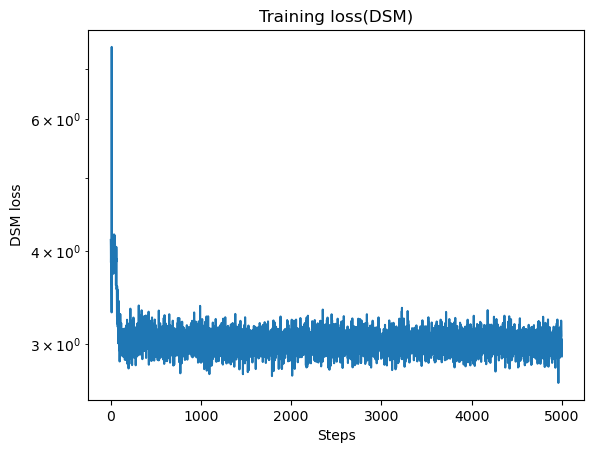

In [10]:
plt.plot(loss_history)
plt.xlabel("Steps")
plt.ylabel("DSM loss")
plt.yscale("log")
plt.title("Training loss(DSM)")
plt.show

t=  0.0 | MSE(score) = 9.211699e-03
t=  2.0 | MSE(score) = 5.478108e-02
t=  5.0 | MSE(score) = 9.472470e-02
t= 10.0 | MSE(score) = 9.438983e-02
t= 15.0 | MSE(score) = 9.371872e-02
t= 20.0 | MSE(score) = 8.819105e-02


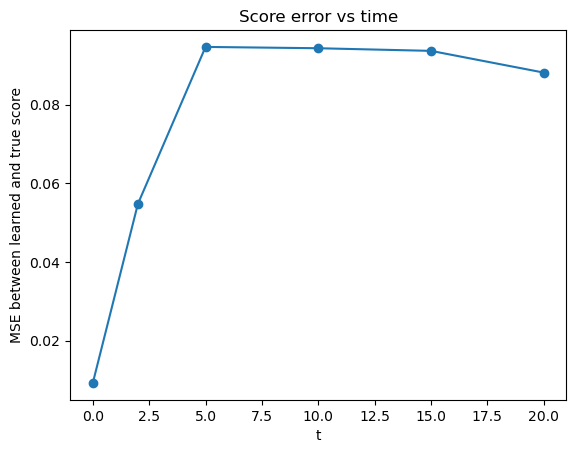

In [15]:
###  跟真實OU score 比較(MSE loss)
def eval_score_mse_at_t(t_eval, n_points=2000):
    # 固定 t_eval 抽一堆x_t
    t_arr = np.full((n_points, 1), t_eval, dtype=np.float32)
    m=mean_t(t_arr)
    v=var_t(t_arr)
    x_arr = m+np.sqrt(v)*np.random.randn(n_points, 1).astype(np.float32)

    # true score
    s_true=true_score_np(x_arr, t_arr)  ## (N,1)
    
    # Model score
    x=torch.from_numpy(x_arr).to(device)
    t=torch.from_numpy(t_arr).to(device)
    model.eval()
    with torch.no_grad():
        s_hat = model(x,t).cpu().numpy()

    mse=np.mean((s_hat-s_true)**2)
    
    return mse, x_arr, s_true, s_hat

t_list=[0.0, 2.0, 5.0, 10.0, 15.0, 20.0]
mses=[]
for t_eval in t_list:
    mse, _, _, _=eval_score_mse_at_t(t_eval)
    mses.append(mse)
    print(f"t= {t_eval:4.1f} | MSE(score) = {mse:.6e}")

plt.plot(t_list, mses, marker="o")
plt.xlabel("t")
plt.ylabel("MSE between learned and true score")
plt.title("Score error vs time")
plt.show()




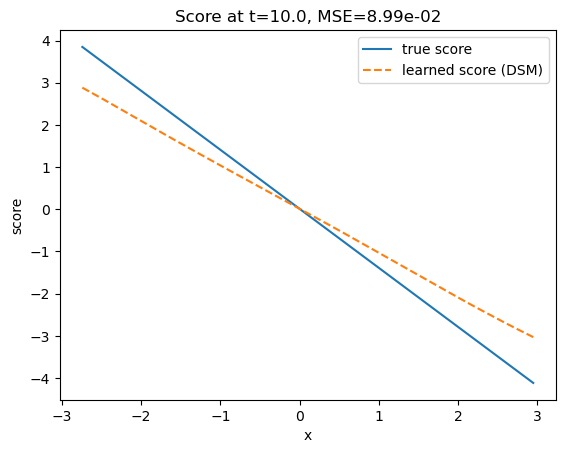

In [16]:
# 選一個時間，直接畫出 score(x,t) 的曲線
t_eval = 10.0

mse, x_arr, s_true, s_hat = eval_score_mse_at_t(t_eval)

order = np.argsort(x_arr[:,0])
x_sorted = x_arr[order,0]
s_true_sorted = s_true[order,0]
s_hat_sorted  = s_hat[order,0]

plt.plot(x_sorted, s_true_sorted, label="true score")
plt.plot(x_sorted, s_hat_sorted,  "--", label="learned score (DSM)")
plt.xlabel("x")
plt.ylabel("score")
plt.title(f"Score at t={t_eval}, MSE={mse:.2e}")
plt.legend()
plt.show()


### Sampling: Reverse SDE
* True Score SDE(OU): 
$$
dX_t=[-\beta(X_t-\mu_{\infty})-\sigma^2\nabla_x\log{p_t(x)}]dt+\sigma dW_t
$$
* DSM score

In [ ]:
def reverse_sde_step_ou(x, t, dt, score_fn, rng):
    """
    x: (N,1) numpy array，現在時間 t 的粒子位置
    t: scalar float (現在時間)
    dt: scalar float (可以是負的：我們從 T 往 0 走)
    score_fn: function(x, t) -> (N,1) numpy array
    rng: numpy random generator
    """
    # score: (N,1)
    score = score_fn(x, t)

    # drift (使用 OU 的 forward drift -beta * x，再加上 -sigma^2 * score)
    drift = -beta * x - (sigma**2) * score

    # noise：注意是 sqrt(|dt|)！
    dw = rng.normal(0.0, 1.0, size=x.shape) * np.sqrt(abs(dt))

    # 反向 SDE update
    x_new = x + drift * dt + sigma * dw  
    return x_new


def sample_reverse_ou_fast(score_fn, N, T, dt, seed):
    rng = np.random.default_rng(seed)

    # 初始化在 t=T
    mT = mean_t(T)
    vT = var_t(T)
    x = rng.normal(mT, np.sqrt(vT), size=(N,1))

    steps = int(T/dt)
    t = T

    for _ in range(steps):
        # vectorized reverse SDE step
        score = score_fn(x, t)  # now fast!
        drift = -beta * x - sigma**2 * score           #### drift=> +-score
        dw = rng.normal(0, 1, size=x.shape) * np.sqrt(dt)
        x = x + drift * (-dt) + sigma * dw

        t -= dt

    return x


def score_true(x, t):
    # x: (N,1) numpy, t: scalar
    return true_score_np(x, t)

def score_dsm(x, t):
    """
    x: (N,1) numpy array
    t: scalar float
    return (N,1) numpy array of score
    """
    x_torch = torch.from_numpy(x.astype(np.float32)).to(device)

    # 建立一次性的 t tensor，不要在 reverse SDE loop 裡重複建立
    t_torch = torch.full((x.shape[0], 1), float(t), dtype=torch.float32, device=device)

    with torch.no_grad():
        s = model(x_torch, t_torch).cpu().numpy()

    return s


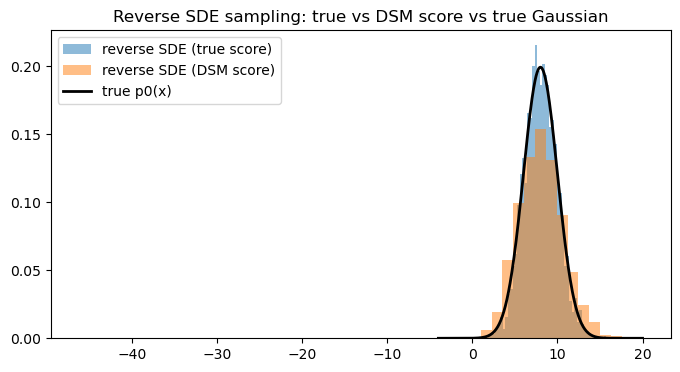

In [27]:
device = torch.device("cpu")
## ---參數跟之前差不多
beta=0.7
sigma=1.0   ## OU SDE's noise level
T=20.0
t_target=10.0
dt=5e-3  #時間步長

mu1=8.0
s1=2.0

K_traj=10  #trajectories 數量
N_part=6000 #估計pdf形狀的OU粒子數

seed=0
rng = np.random.default_rng(seed)

#----------------------------

# 1) 用真實 OU score 做 reverse SDE
x_true = sample_reverse_ou_fast(score_true, N=2000, T=T, dt=0.02, seed=0)

# 2) 用 DSM score 做 reverse SDE
x_dsm  = sample_reverse_ou_fast(score_dsm, N=2000, T=T, dt=0.02, seed=1)

# 3) 畫 histogram + 真實 Gaussian p0(x)
xs = np.linspace(mu1-6*s1, mu1+6*s1, 400)
p0 = (1.0 / (np.sqrt(2*np.pi)*s1)) * np.exp(-(xs-mu1)**2 / (2*s1**2))

plt.figure(figsize=(8,4))
plt.hist(x_true, bins=50, density=True, alpha=0.5, label="reverse SDE (true score)")
plt.hist(x_dsm,  bins=50, density=True, alpha=0.5, label="reverse SDE (DSM score)")
plt.plot(xs, p0, 'k', lw=2, label="true p0(x)")
plt.legend()
plt.title("Reverse SDE sampling: true vs DSM score vs true Gaussian")
plt.show()


### 畫軌跡 : Reverse OU vs. Reverse DSM

In [31]:
def reverse_ou_with_traj(score_fn, 
                         x_init, 
                         T=20.0, dt=0.02):
    """
    score_fn: score(x, t) -> (N,1)
    x_init  : (N,1) 初始在 t=T 的樣本
    return:
        xs_traj: (steps+1, N, 1)
        ts     : (steps+1,)
    """
    rng = np.random.default_rng(0)

    x = x_init.copy()
    dt_pos = dt
    steps = int(T / dt_pos)

    xs = [x.copy()]
    ts = [T]

    t = T
    for _ in range(steps):
        score = score_fn(x, t)
        drift = -beta * x - sigma**2 * score
        dw = rng.normal(0,1,size=x.shape) * np.sqrt(dt_pos)
        x = x + drift*(-dt_pos) + sigma * dw
        t -= dt_pos
        
        xs.append(x.copy())
        ts.append(t)

    return np.stack(xs), np.array(ts)

## 從t=0開始造reverse的起點
# generate x_T initial for reverse
mT = mean_t(T)
vT = var_t(T)
x_T = np.random.randn(6000,1) * np.sqrt(vT) + mT

# == TRUE OU score function ==
def score_true(x, t):
    # x: (N,1) numpy, t: scalar
    return true_score_np(x, t)

def score_dsm(x, t):
    """
    x: (N,1) numpy array
    t: scalar float
    return (N,1) numpy array of score
    """
    x_torch = torch.from_numpy(x.astype(np.float32)).to(device)

    # 建立一次性的 t tensor，不要在 reverse SDE loop 裡重複建立
    t_torch = torch.full((x.shape[0], 1), float(t), dtype=torch.float32, device=device)

    with torch.no_grad():
        s = model(x_torch, t_torch).cpu().numpy()

    return s

# === Reverse trajectories ===
xs_true, ts_true = reverse_ou_with_traj(score_true, x_T)
xs_dsm, ts_dsm  = reverse_ou_with_traj(score_dsm,  x_T)


In [33]:
def pdf_from_samples(xs, ys, bins=50):
    """
    xs: samples (N,1)
    ys: y grid
    return estimated pdf on ys
    """
    hist, edges = np.histogram(xs.squeeze(), bins=bins, density=True)
    centers = 0.5*(edges[:-1] + edges[1:])
    return np.interp(ys, centers, hist)


In [34]:
def plot_reverse(traj_true, traj_dsm, ts, 
                 t_target, 
                 mu1, s1, 
                 beta, sigma,
                 bins=60):
    """
    traj_true: (steps+1, N, 1)  真實 reverse OU trajectories
    traj_dsm : (steps+1, N, 1)  DSM reverse trajectories
    ts       : (steps+1,)       對應的時間序列
    """

    fig = plt.figure(figsize=(12, 2.5))
    gs = GridSpec(nrows=1, ncols=3, width_ratios=[1.2, 10, 1.2], wspace=0.30)

    ax_left  = fig.add_subplot(gs[0,0])   # t=0
    ax_main  = fig.add_subplot(gs[0,1])   # trajectories
    ax_right = fig.add_subplot(gs[0,2])   # t=T

    # ===============================
    # 1. 中間軌跡
    # ===============================

    K = 10  # 顯示10條
    for k in range(K):
        ax_main.plot(ts, traj_true[:, k], color="tab:green", alpha=0.7, lw=1)
        ax_main.plot(ts, traj_dsm[:, k],  color="tab:orange", alpha=0.8, lw=1)

    ax_main.set_xlabel("$t$")
    ymin = min(traj_true.min(), traj_dsm.min())
    ymax = max(traj_true.max(), traj_dsm.max())
    pad = 0.2*(ymax - ymin)
    ylims = (ymin - pad, ymax + pad)
    ax_main.set_ylim(ylims)
    ys = np.linspace(*ylims, 700)

    # ===============================
    # 2. 左：t = 0 的分布
    # ===============================
    xs0_true = traj_true[-1]   # 因為 reverse 是從 T → 0，最後 index = 0
    xs0_dsm  = traj_dsm[-1]

    pdf0_true = pdf_from_samples(xs0_true, ys, bins=bins)
    pdf0_dsm  = pdf_from_samples(xs0_dsm,  ys, bins=bins)

    ax_left.plot(pdf0_true, ys, color="tab:green", linewidth=2, label="rev-OU")
    ax_left.plot(pdf0_dsm,  ys, color="tab:orange", linewidth=2, label="rev-DSM")

    ax_left.set_ylim(ylims); ax_left.set_xlim(left=0)
    ax_left.set_yticks([])
    ax_left.set_xlabel("$p_0(x)$", labelpad=6)
    ax_left.spines["top"].set_visible(False)
    ax_left.spines["right"].set_visible(False)
    ax_left.legend(fontsize=8)

    # ===============================
    # 3. 中間：t = t_target 的 PDF 疊在 main 上
    # ===============================
    idx_mid = np.argmin(np.abs(ts - t_target))

    x_mid_true = traj_true[idx_mid]
    x_mid_dsm  = traj_dsm[idx_mid]

    pdf_mid_true = pdf_from_samples(x_mid_true, ys)
    pdf_mid_dsm  = pdf_from_samples(x_mid_dsm,  ys)

    scale = 0.25 / max(pdf_mid_true.max(), pdf_mid_dsm.max())

    ax_main.plot(t_target + scale*pdf_mid_true/pdf_mid_true.max(), ys,
                 color="tab:green", lw=2)
    ax_main.plot(t_target + scale*pdf_mid_dsm/pdf_mid_dsm.max(), ys,
                 color="tab:orange", lw=2)
    ax_main.axvline(t_target, color="0.7", linestyle="--")

    # ===============================
    # 4. 右：t=T 的分布
    # ===============================
    xsT_true = traj_true[0]  # 起點
    xsT_dsm  = traj_dsm[0]

    pdfT_true = pdf_from_samples(xsT_true, ys, bins=bins)
    pdfT_dsm  = pdf_from_samples(xsT_dsm,  ys, bins=bins)

    ax_right.plot(pdfT_true, ys, color="tab:green", linewidth=2)
    ax_right.plot(pdfT_dsm,  ys, color="tab:orange", linewidth=2)

    ax_right.set_ylim(ylims); ax_right.set_xlim(left=0)
    ax_right.set_yticks([])
    ax_right.set_xlabel("$p_T(x)$", labelpad=6)
    ax_right.yaxis.tick_right()
    ax_right.spines["top"].set_visible(False)
    ax_right.spines["left"].set_visible(False)

    plt.show()


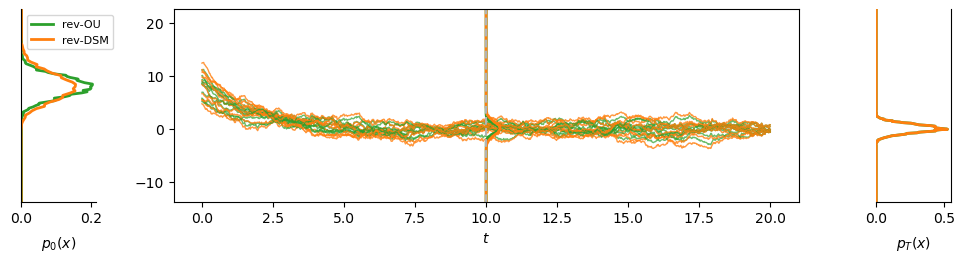

In [35]:
traj_true, ts = xs_true, ts_true   # reverse OU trajectories
traj_dsm,  _  = xs_dsm , ts_dsm    # reverse DSM trajectories
plot_reverse(traj_true, traj_dsm, ts, 
             t_target=10.0,
             mu1=mu1, s1=s1,
             beta=beta, sigma=sigma)


---

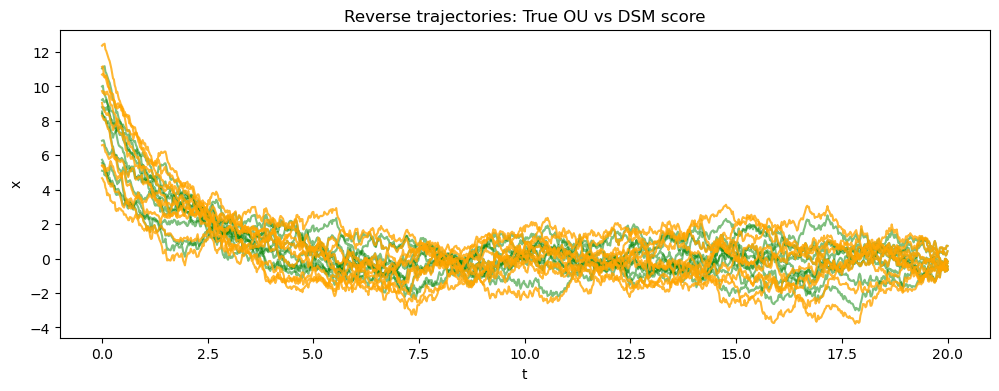

In [32]:
K_show = 10   # 顯示 10 條

plt.figure(figsize=(12,4))

# 前向 OU 的 10 條（如果你有存 forward trajectories）
# plt.plot(times_fwd, xs_fwd[:, :K_show], "g", alpha=0.6)

# 真實 reverse OU（綠色）
for k in range(K_show):
    plt.plot(ts_true, xs_true[:,k], color="green", alpha=0.5)

# DSM reverse（橘色）
for k in range(K_show):
    plt.plot(ts_dsm, xs_dsm[:,k], color="orange", alpha=0.8)

plt.title("Reverse trajectories: True OU vs DSM score")
plt.xlabel("t")
plt.ylabel("x")
plt.show()


In [30]:
losses = []
for i, t in enumerate(ts_dsm):
    x = xs_dsm[i]     # (N,1)
    s_true_t = score_true(x, t)
    s_dsm_t  = score_dsm(x, t)
    mse = np.mean((s_true_t - s_dsm_t)**2)
    losses.append(mse)

plt.plot(ts_dsm, losses)
plt.title("DSM score error vs time (reverse sampling)")
plt.xlabel("t")
plt.ylabel("MSE(score)")
plt.show()


KeyboardInterrupt: 